In this notebook we test for the medium filter set case using the MNIST dataset. We are evaluating the performance of Penalized Subset Scan with Matched Filters using MNIST. The true subset is an image in the MNIST test dataset that we do not have access to at the beginning. The filter set consists of multiple images from the MNIST traning dataset. We want to pick the most reasonable filter from the filter set and then detect the subset using the filter.

In [15]:
# !pip install python-mnist

In [22]:
# from mnist import MNIST
import random
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.stats import bernoulli
from itertools import product
import matplotlib.pyplot as plt
from functools import partial
from scipy import optimize, ndimage
from sklearn.cluster import DBSCAN

In [23]:
with open('test_set.pkl', 'rb') as f: 
    subset = pickle.load(f)

with open('theta.pkl', 'rb') as f: 
    theta = pickle.load(f)

with open('btree_v2.pkl', 'rb') as f: 
    tree = pickle.load(f)

with open('circles_filled_dataset.pkl', 'rb') as f:
    circles = pickle.load(f)

with open('circles_tree.pkl', 'rb') as f:
    c_tree = pickle.load(f)


train = theta.to_numpy()
test = subset.to_numpy()

c_train = circles.iloc[:, :784].to_numpy()

In [24]:
# #Download mnist as filters
# train, _ = mndata.load_training()
# train = np.array(train)
# train = (train>=200).astype(int)
# test, _ = mndata.load_testing()
# test = np.array(test)
# test = (test>=200).astype(int)

In [25]:
#Metrics
def calc_prec(subset_con, filter_true):
    return np.sum((subset_con == 1) & (filter_true == 1))/ np.sum(subset_con == 1) 

def calc_recall(subset_con, filter_true):
    return np.sum((subset_con == 1) & (filter_true == 1))/ np.sum(filter_true == 1) 

def f1(prec, recall):
    return 2*((prec*recall)/(prec+recall))

In [26]:
num_locations = 784
num_hash_tables = 20
hash_tables = []
for i in range(num_hash_tables):
    hash_tables.append(dict(dict(num_element = 0)))
    
p_filter = np.mean(train.sum(axis=0)/theta.shape[0])
partition_size = int(round(1/p_filter))
num_partitions_per_hash = 25 #int(round(log_num_filters*(np.log(2)/np.log(1+partition_size))))
#num_partitions = num_partitions_per_hash* num_hash_tables
partitions = []
for i in range(num_hash_tables):
    cur_partitions = []
    for i in range(num_partitions_per_hash):
        cur_partitions.append(np.random.choice(num_locations,size=partition_size,replace=False))
    partitions.append(cur_partitions)

In [27]:
#Log Likelihood Ratio Functions (natural log)

def llri(OBS, exp, q): #score function for poisson (one element)
    return OBS*np.log(q) + exp*(1-q)

def llri_pen(OBS, exp, q, delta): #penalized score function for poisson (one element)
    return OBS*np.log(q) + exp*(1-q) - delta

llr = np.vectorize(llri) #generate unpenalized scores for a given q value

llr_pen = np.vectorize(llri_pen) #genereate penalized scores for a given q value

poissons = np.vectorize(lambda x: np.random.poisson(x))


#DEFINED FUNCTIONS FOR USE IN ALGORITHM:

#BINARY SEARCH FUNCTIONS: ################################################
def q_min(OBS, exp):

    minimum = 0.000001
    qmle = OBS/exp

    while abs(qmle - minimum) > 0.00000001:
        q_mid = (minimum + qmle)/2

        if llri(OBS, exp, q_mid) > 0:
            qmle = qmle - (qmle - minimum)/2
        else:
            minimum = minimum + (qmle - minimum)/2
    return (minimum + qmle)/2

def q_max(OBS, exp):

    maximum = 10000000
    qmle = OBS/exp

    while abs(maximum - qmle) > 0.000001:
        q_mid = (maximum + qmle)/2

        if llri(OBS, exp, q_mid) < 0:
            maximum = maximum - (maximum-qmle)/2
        else:
            qmle = qmle + (maximum-qmle)/2

    return (maximum + qmle)/2

###################################################
def q_min_pen(OBS, exp, delta):  #need to fix


    minimum = 0.000001
    qmle = OBS/exp

    while abs(qmle - minimum) > 0.00000001:
        q_mid = (minimum + qmle)/2

        if llri_pen(OBS, exp, q_mid, delta) > 0:
            qmle = qmle - (qmle - minimum)/2
        else:
            minimum = minimum + (qmle - minimum)/2
    return (minimum + qmle)/2
####################################################

def q_max_pen(OBS, exp, delta):

    maximum = 10000000
    qmle = OBS/exp

    while abs(maximum - qmle) > 0.000001:
        q_mid = (maximum + qmle)/2

        if llri_pen(OBS, exp, q_mid, delta) < 0:
            maximum = maximum - (maximum-qmle)/2
        else:
            qmle = qmle + (maximum-qmle)/2

    return (maximum + qmle)/2
######################################################################################


#FOR FINDING Q-INTERVALS: ###################################################################################
def minmax(OBS, exp):
    return (q_min(OBS, exp), q_max(OBS, exp))

def minmax_pen(OBS, exp, delta):
    return [q_min_pen(OBS, exp, delta), q_max_pen(OBS, exp, delta)]

#Get q intervals
def get_q_values(OBS, exp, delta):
    return np.array([q_min(OBS, exp), q_min_pen(OBS, exp, delta), q_max_pen(OBS, exp, delta), q_max(OBS, exp)])

get_all_intervals = np.vectorize(get_q_values)
#############################################################################################################

def relu_scores(scores, delta):
    return min(np.abs(scores), delta)

def ReLU(scores):
    return (scores > 0).view('i1')


def compute_new_subset(scores, filter, delta):
    
    subset = np.zeros(len(filter))
    weights = np.zeros(len(filter))
    penalties = np.zeros(len(filter))

    for i in range(len(filter)):

        if (scores[i] > delta):

            if filter[i] == 0:
                penalties[i] = delta
            
            subset[i] = 1 #always include element in subset
            weights[i] = delta #w_i = delta

        elif (np.abs(scores[i]) <= delta):

            subset[i] = filter[i] #include iff in filter
            weights[i] = np.abs(scores[i]) #w_i = score_i

        else:

            if filter[i] == 1: #penalize by delta if in filter
                penalties[i] = delta
                
            subset[i] = 0 #always exclude from subset
            weights[i] = delta #w_i = delta
            
    return subset, weights

def jaccard(best_s, observed):
    # best_s = np.asarray(best_s).astype(bool)
    # observed = np.asarray(observed).astype(bool)
    if best_s.shape != observed.shape:
        raise ValueError("Shape mismatch: best_s and observed must have the same shape.")
    intersection = np.logical_and(best_s, observed)
    union = np.logical_or(best_s, observed)
    return intersection.sum() / float(union.sum())

In [28]:
k = -1
step_size = 5
num_filters = train.shape[0]
def hashit(thefilter,partitions):
    toreturn = []
    for thepartition in partitions:
        temp = (list(map(lambda x: thefilter[x],thepartition.tolist())) + [1]).index(1)
        toreturn.append(temp)
    return toreturn

for i in range(num_filters):
    thefilter = train[i]
    for j in range(num_hash_tables):
        depth = 0
        current_partition = partitions[j][depth*step_size: (depth+1)*step_size]
        fullbitstring = hashit(thefilter,current_partition)
        depth += 1
        root = hash_tables[j]
        root['num_element'] += 1
        if tuple(fullbitstring) not in root:
            root[tuple(fullbitstring)] = []
        current_node = root[tuple(fullbitstring)]
        prev = root
        while(type(current_node) != list):
            current_node['num_element'] += 1
            current_partition = partitions[j][depth*step_size: (depth+1)*step_size]
            fullbitstring = hashit(thefilter,current_partition)
            depth += 1
            if tuple(fullbitstring) not in current_node:
                current_node[tuple(fullbitstring)] = []
            prev = current_node
            current_node = current_node[tuple(fullbitstring)]
        current_node.append(i)
        if depth < 5:
            l = len(current_node)
            if l > 100:
                last_string = fullbitstring
                current_partition = partitions[j][depth*step_size: (depth+1)*step_size]
                new_node = {}
                new_node['num_element'] = l
                for element in current_node:
                    filter_tmp = train[element]
                    fullbitstring = hashit(filter_tmp,current_partition)
                    if tuple(fullbitstring) not in new_node:
                        new_node[tuple(fullbitstring)] = []
                    new_node[tuple(fullbitstring)].append(element)
                prev[tuple(last_string)] = new_node

In [29]:
Maxnode = 500

def traverse_tree(node):
    global matches_sub
    if len(matches_sub) > Maxnode:
        return
    if type(node) == list:
        matches_sub += node
    else:
        for i in node.keys():
            if i != 'num_element':
                traverse_tree(node[i])
                
def filter_finder(subset, obs):
    thequery = subset 
    matches = []
    for j in range(num_hash_tables):
        depth = 0
        current_partition = partitions[j][depth*step_size: (depth+1)*step_size]
        fullbitstring = hashit(thequery,current_partition)
        depth += 1
        current_node = hash_tables[j]
        while(tuple(fullbitstring) in current_node):
            current_node = current_node[tuple(fullbitstring)]
            current_partition = partitions[j][depth*step_size: (depth+1)*step_size]
            fullbitstring = hashit(thequery,current_partition)
            depth += 1
        l = current_node['num_element'] if type(current_node) == dict else len(current_node)
        while(l > Maxnode and type(current_node) != list):
            if tuple(fullbitstring) in current_node:
                current_node = current_node[tuple(fullbitstring)]
            else:
                key_list = [np.array(i) for i in list(current_node.keys()) if i != 'num_element']
                M_list = [(np.array(fullbitstring)==k).sum() for k in key_list]
                num_list = []
                M = max(M_list)
                num = float('inf')
                for k in range(len(M_list)):
                    if M_list[k] == M:
                        cur_num = current_node[tuple(key_list[k])]['num_element'] if type(current_node[tuple(key_list[k])]) == dict else len(current_node[tuple(key_list[k])])
                        if cur_num < num:
                            num = cur_num
                            cur_idx = k
                current_node = current_node[tuple(key_list[k])]
            l = current_node['num_element'] if type(current_node) == dict else len(current_node)
            current_partition = partitions[j][depth*step_size: (depth+1)*step_size]
            fullbitstring = hashit(thequery,current_partition)
            depth += 1
        global matches_sub
        matches_sub = []
        traverse_tree(current_node)
        matches += matches_sub
    matches = np.unique(matches)
    return matches

def func(x, obs, lam, pel):
    return (obs * np.log(x) + lam * (1 - x) + pel)

def minus_func(x, obs, lam, pel):
    return -(obs * np.log(x) + lam * (1 - x) + pel)

def func_prime(x, obs, lam, pel):
    return obs/x - lam 
def func_prime2(x, obs, lam, pel):
    return -obs/x**2 

def solve_q_max(x, u, p, root=True):
    if(x == 0):
        x=1
    partial_func = partial(func, lam=u, obs=x, pel=p)
    partial_func_prime = partial(func_prime, lam=u, obs=x, pel=p)
    partial_func_prime2 = partial(func_prime2, lam=u, obs=x, pel=p)
    q_max = x / u

    if (not root):
        return q_max
    else:
        if(func(q_max, x, u ,p) <= 0):
            return q_max, 1, 1
        else:
            
            tmp = q_max
            while(partial_func(tmp)>0):
                tmp /= 2
            q_1 = optimize.newton(partial_func,tmp, fprime=partial_func_prime, maxiter=1000, fprime2=partial_func_prime2)
            tmp=q_max    
            while(partial_func(tmp)>0):
                tmp *= 2
            q_0 = optimize.newton(partial_func, tmp, fprime=partial_func_prime, maxiter=1000, fprime2=partial_func_prime2)
            
            if(q_0 < 1):
                q_0 = 1
            if(q_1 < 1):
                q_1 = 1
        return q_max, q_1, q_0
            

def ALTSS(x, u, p):
    S_max = -np.inf
    q_1_s, q_0_s = [], []

    for i in range(len(x)):
        _, q_1, q_0 = solve_q_max(x[i], u[i], p[i])
        q_1_s.append(q_1)
        q_0_s.append(q_0)

    q_range = np.sort(np.unique(np.concatenate([[1], q_0_s, q_1_s])))
    for i in range(len(q_range) - 1):
        u_sub = sum(u[(q_0_s >= q_range[i + 1]) & (q_1_s <= q_range[i])])
        if(u_sub==0):
            continue
        x_sub = sum(x[(q_0_s >= q_range[i + 1]) & (q_1_s <= q_range[i])])
        p_sub = sum(p[(q_0_s >= q_range[i + 1]) & (q_1_s <= q_range[i])])
        if(x_sub/u_sub<=q_range[i + 1] and x_sub/u_sub>=q_range[i]):
            q_tmp = x_sub/u_sub
        elif func(q_range[i], x_sub, u_sub, p_sub) > func(q_range[i+1], x_sub, u_sub, p_sub):
            q_tmp =q_range[i]
        else:
            q_tmp =q_range[i+1]
        S_tmp = func(q_tmp, x_sub, u_sub, p_sub)

        if (S_tmp > S_max):
            q_max = q_tmp
            S_max = S_tmp
            i_max = i
            
    return (q_0_s >= q_range[i_max + 1]) & (q_1_s <= q_range[i_max]) + 0, S_max, q_max


def pel_constructive_single(obs, lam):
    global P_I_I, P_O_I, P_I_O, subset, ini_tmp
    n_point = len(obs)

    try:
        subset_un, S3_max, q_un = ALTSS(obs, lam, np.zeros(n_point))
    except KeyError as e:
        print("KeyError:", e)
        
    subset = subset_un
    matches = filter_finder(subset, obs)
    k = 0
    S_max = -float('inf')
    while (k < 10):
        k += 1
        a = [np.sum(np.abs(filters[i] - subset)) for i in matches]
        ini_idx = matches[a.index(min(a))]
        ini_new = filters[ini_idx]
        pel = (P_I_O) * ini_new -  P_O_I * (1 - ini_new)
        subset_new, S4_max, q_pel = ALTSS(obs, lam, pel)
        S4_max -= (P_I_O) * sum(ini_new)
        if (sum(abs(subset_new - subset)) == 0):
            break
        else: 
            matches = filter_finder(subset_new, obs)
        

        if (sum(abs(subset_new - ini_new)) == 0):
            break
        subset = subset_new
    subset_con = subset_new
    return subset_un, subset_con, q_un, q_pel, pel

def pel_constructive_single_uls(obs, lam):
    global P_I_I, P_O_I, P_I_O, subset, ini_tmp
    n_point = len(obs)
    subset_un, S3_max, q_un = ALTSS(obs, lam, np.zeros(n_point))
    scores = []
    for i in range(len(obs)):
        scores.append(func(q_un, obs[i], lam[i], 0))
    sub = uls_score(scores)
    subset = sub
    matches = filter_finder(subset, obs)
    k = 0
    S_max = -float('inf')
    while (k < 10):
        k += 1
        a = [np.sum(np.abs(filters[i] - subset)) for i in matches]
        ini_idx = matches[a.index(min(a))]
        ini_new = filters[ini_idx]
        pel = (P_I_O) * ini_new -  P_O_I * (1 - ini_new)
        subset_new, S4_max, q_pel = ALTSS(obs, lam, pel)
        scores = []
        for i in range(len(obs)):
            scores.append(func(q_pel, obs[i], lam[i], pel[i]))
        sub = uls_score(scores).astype(int)
        subset_new = sub
        
        if (sum(abs(subset_new - subset)) == 0):
            break
        else: 
            matches = filter_finder(subset_new, obs)
        

        if (sum(abs(subset_new - ini_new)) == 0):
            break
        subset = subset_new
    subset_con = subset_new
    return subset_un, subset_con, q_un, q_pel, pel

def uls_score(scores):
    scores = np.array(scores)
    s_max = -np.inf
    for j in scores:
        binary_img = (scores>j).reshape(28, 28)
        label_im, nb_labels = ndimage.label(binary_img, structure= [[1,1,1],[1,1,1], [1,1,1]])
        for k in range(1, nb_labels + 1):
            sub = (label_im == k).reshape(-1)
            s = np.sum(scores[sub])
            if s>s_max:
                s_max = s
                sub_uls = sub
    return sub_uls

def uls(obs, lam):
    scores = obs/lam
    s_max = -np.inf
    for j in scores:
        binary_img = (scores>j).reshape(28, 28)
        label_im, nb_labels = ndimage.label(binary_img, structure= [[1,1,1],[1,1,1], [1,1,1]])
        for k in range(1, nb_labels + 1):
            sub = (label_im == k).reshape(-1)
            x = np.sum(obs[sub])
            u = np.sum(lam[sub])
            q = x/u
            s = func(q, x, u, 0)
            if s>s_max:
                s_max = s
                sub_uls = sub
    return sub_uls

def pel_constructive_single_2(obs, lam):
    global P_I_I, P_O_I, P_I_O, subset, ini_tmp
    n_point = len(obs)
    subset_un, S3_max, q_un = ALTSS(obs, lam, np.zeros(n_point))
    subset = subset_un
    plt.subplot(222)
    plt.imshow(subset_un.reshape(28,28))
    plt.title('unpenalized subset')
    matches = filter_finder(subset, obs)
    k = 0
    S_max = -float('inf')
    while (k < 10):
        k += 1
        a = [np.sum(np.abs(filters[i] - subset)) for i in matches]
        ini_idx = matches[a.index(min(a))]
        ini_new = filters[ini_idx]
        pel = (P_I_O) * ini_new -  P_O_I * (1 - ini_new)
        subset_new, S4_max, q_pel = ALTSS(obs, lam, pel)
        if (sum(abs(subset_new - subset)) == 0):
            plt.subplot(223)
            plt.imshow(ini_new.reshape(28,28))
            plt.title('matched filter')
            
            plt.subplot(224)
            plt.imshow(subset_new.reshape(28,28))
            plt.title('subset with matched filter')
            break
        else: 
            matches = filter_finder(subset_new, obs)
        

        if ((sum(abs(subset_new - ini_new)) == 0) or (k==9)):
            plt.subplot(223)
            plt.imshow(ini_new.reshape(28,28))
            plt.title('matched filter')
            
            plt.subplot(224)
            plt.imshow(subset_new.reshape(28,28))
            plt.title('subset with matched filter')
            break
        subset = subset_new
    subset_con = subset_new
    return subset_un, subset_con, q_un, q_pel, pel

#note: 'filters' is undefined. Renaming all instances of 'filters' to 'theta' to try and fix this. -Jackson
#note: 'lam' is also undefined. From the looks of the code, I believe it is supposed to be the expected counts for poisson

In [30]:
Maxnode = 500

def traverse_tree(node):
    global matches_sub
    if len(matches_sub) > Maxnode:
        return
    if type(node) == list:
        matches_sub += node
    else:
        for i in node.keys():
            if i != 'num_element':
                traverse_tree(node[i])
                
def filter_finder(subset, obs):
    thequery = subset 
    matches = []
    for j in range(num_hash_tables):
        depth = 0
        current_partition = partitions[j][depth*step_size: (depth+1)*step_size]
        fullbitstring = hashit(thequery,current_partition)
        depth += 1
        current_node = hash_tables[j]
        while(tuple(fullbitstring) in current_node):
            current_node = current_node[tuple(fullbitstring)]
            current_partition = partitions[j][depth*step_size: (depth+1)*step_size]
            fullbitstring = hashit(thequery,current_partition)
            depth += 1
        l = current_node['num_element'] if type(current_node) == dict else len(current_node)
        while(l > Maxnode and type(current_node) != list):
            if tuple(fullbitstring) in current_node:
                current_node = current_node[tuple(fullbitstring)]
            else:
                key_list = [np.array(i) for i in list(current_node.keys()) if i != 'num_element']
                M_list = [(np.array(fullbitstring)==k).sum() for k in key_list]
                num_list = []
                M = max(M_list)
                num = float('inf')
                for k in range(len(M_list)):
                    if M_list[k] == M:
                        cur_num = current_node[tuple(key_list[k])]['num_element'] if type(current_node[tuple(key_list[k])]) == dict else len(current_node[tuple(key_list[k])])
                        if cur_num < num:
                            num = cur_num
                            cur_idx = k
                current_node = current_node[tuple(key_list[k])]
            l = current_node['num_element'] if type(current_node) == dict else len(current_node)
            current_partition = partitions[j][depth*step_size: (depth+1)*step_size]
            fullbitstring = hashit(thequery,current_partition)
            depth += 1
        global matches_sub
        matches_sub = []
        traverse_tree(current_node)
        matches += matches_sub
    matches = np.unique(matches)
    return matches


def pel_constructive_single_2(obs, lam):
    global P_I_I, P_O_I, P_I_O, subset, ini_tmp
    n_point = len(obs)

    #construct unpenalized subset using Additive Linear Time Subset Scanning method
    subset_un, S3_max, q_un = ALTSS(obs, lam, np.zeros(n_point))
    subset = subset_un
    plt.subplot(222)
    plt.imshow(subset_un.reshape(28,28))
    plt.title('unpenalized subset')

    #use filter_finder method defined above to find 'matches'?
    matches = filter_finder(subset, obs)
    k = 0
    S_max = -float('inf')
    while (k < 10):
        k += 1

        #find distance to each filter from our subset identified earlier?
        a = [np.sum(np.abs(filters[i] - subset)) for i in matches]

        #find filter with the least distance
        ini_idx = matches[a.index(min(a))]

        #new filter?
        ini_new = filters[ini_idx]

        #penalty?
        pel = (P_I_O) * ini_new -  P_O_I * (1 - ini_new)

        #compute new subset using ALTSS
        subset_new, S4_max, q_pel = ALTSS(obs, lam, pel)

        #if new subset does not change from the old subset, plot it
        if (sum(abs(subset_new - subset)) == 0):
            plt.subplot(132)
            plt.imshow(ini_new.reshape(28,28))
            plt.title('matched filter')
            
            plt.subplot(133)
            plt.imshow(subset_new.reshape(28,28))
            plt.title('subset with matched filter')
            break
        else: #find matched filter for new subset
            matches = filter_finder(subset_new, obs)
        
        #if filter and subset converge, or we reach our maximum number of specified iterations, break, plot results
        if ((sum(abs(subset_new - ini_new)) == 0) or (k==9)):
            plt.subplot(132)
            plt.imshow(ini_new.reshape(28,28))
            plt.title('matched filter')
            
            plt.subplot(133)
            plt.imshow(subset_new.reshape(28,28))
            plt.title('subset with matched filter')
            break
        subset = subset_new
    subset_con = subset_new
    return subset_un, subset_con, q_un, q_pel, pel

In [31]:
#NEW MATCHED FILTER:
###########################################################################

def matched_filter(observed, expected, delta, tree):
    
    for i in range(len(observed)):
        if i == 0:
            q_values = get_q_values(observed[i], expected[i], delta)
        else:
            q_values = np.append(q_values, get_q_values(observed[i], expected[i], delta))     

    q_values = np.unique(q_values)

    delta = 5
    max_score_per_q_range = []
    max_scoring_qmle_per_q_range = []
    max_scoring_S_per_q_range = []
    max_scoring_filter_per_q_range = []

    for i in range(len(q_values) - 1):

        converged = False
        max_score_for_this_q_range = -1E6
        max_scoring_qmle_for_this_q_range = -1E6
        max_scoring_S_for_this_q_range = None
        max_scoring_filter_for_this_q_range = None

        #INITIAL Q VALUE
        qmid = (q_values[i] + q_values[i+1])/2
        print(f"Initial q value (midpoint of q-range): {qmid:{1}.{5}} \n")

        qmle = qmid
        all_unpenalized_element_scores = llr(observed, expected, qmle) 

        while converged == False:

            # STEP 1: DEFINE INITIAL SUBSET AND WEIGHTS FOR FILTER SEARCH
            S_for_filter_search = ReLU(scores=all_unpenalized_element_scores)
            W_for_filter_search = [delta if np.abs(score) > delta else np.abs(score) for score in all_unpenalized_element_scores]

            # STEP 2: TREE TRAVERSAL TO FIND (APPROXIMATELY) OPTIMAL FILTER FOR GIVEN S, W
            filter, _ = tree.traverse(S_for_filter_search, weights=W_for_filter_search) # traverse tree to find best filter 

            # STEP 3: COMPUTE NEW SUBSET FOR GIVEN FILTER
            S, _ = compute_new_subset(scores=all_unpenalized_element_scores, filter=filter, delta=delta)

            # STEP 4: COMPUTE PENALIZED SCORE OF SUBSET S FOR CURRENT qmle
            # (This step is not strictly necessry, and could be removed to save time)
            unpenalized_score = sum(S*all_unpenalized_element_scores)
            pens = np.ones(len(observed))*delta
            total_penalty = sum(pens[filter != S]) 
            penalized_score = unpenalized_score - total_penalty  
            print("Penalized score for current qmle",qmle,":\n",unpenalized_score,"-",total_penalty,"=",penalized_score)

            # STEP 5: RECOMPUTE qmle
            previous_qmle = qmle
            qmle = sum(observed*S)/(sum(expected*S) + 1E-6)

            # STEP 6: COMPUTE PENALIZED SCORE OF SUBSET S FOR NEW qmle
            all_unpenalized_element_scores = llr(observed,expected,qmle)
            unpenalized_score = sum(S*all_unpenalized_element_scores)
            pens = np.ones(len(observed))*delta
            total_penalty = sum(pens[filter != S]) 
            penalized_score = unpenalized_score - total_penalty  
            print("Penalized score for new qmle",qmle,":\n",unpenalized_score,"-",total_penalty,"=",penalized_score)

            if (penalized_score > max_score_for_this_q_range):
                max_score_for_this_q_range = penalized_score
                max_scoring_qmle_for_this_q_range = qmle
                max_scoring_S_for_this_q_range = S
                max_scoring_filter_for_this_q_range = filter
            else: # move to next if score does not increase
                converged = True

            # move to next if qmle converges, or goes outside the current range
            if (np.abs(qmle - previous_qmle) < 0.001) or (qmle < q_values[i]) or (qmle > q_values[i+1]):
                converged = True

            # otherwise, qmle and all_penalized_element_scores are ready for the next loop iteration
            if not converged:
                print("---------------------------------------------------------------------")

        max_score_per_q_range.append(max_score_for_this_q_range)
        max_scoring_qmle_per_q_range.append(max_scoring_qmle_for_this_q_range)
        max_scoring_S_per_q_range.append(max_scoring_S_for_this_q_range)
        max_scoring_filter_per_q_range.append(max_scoring_filter_for_this_q_range)

        print(f"##################################################################### {i}")

    overall_max_position = np.argmax(max_score_per_q_range)
    overall_max_score = max_score_per_q_range[overall_max_position]
    overall_max_scoring_qmle = max_scoring_qmle_per_q_range[overall_max_position]
    overall_max_scoring_S = max_scoring_S_per_q_range[overall_max_position]
    overall_max_scoring_filter = max_scoring_filter_per_q_range[overall_max_position]

    #DISPLAY RESULTS-----------------------------------------           
    plt.subplot(1, 3, 1)
    plt.imshow(overall_max_scoring_filter.to_numpy().reshape(28,28), cmap='gray')
    plt.title("Matched Filter")

    plt.subplot(1, 3, 2)
    plt.imshow(overall_max_scoring_S.reshape(28,28), cmap='gray')
    plt.title("Best Subset")

    plt.subplot(1, 3, 3)
    plt.imshow(observed.reshape(28,28), cmap='gray')
    plt.title("Observed Subset")

    print(f'Max score: {overall_max_score}, qmle: {overall_max_scoring_qmle}')
    print(f'Jaccard coefficient: {jaccard(overall_max_scoring_S, (expected/10)-1)}')
    print(f'Filter Jaccard coefficient: {jaccard(overall_max_scoring_filter, (expected/10)-1)}')

    return overall_max_scoring_S, overall_max_scoring_filter

In [15]:
baseline = test[2]*10 + 10
obs = poissons(baseline) 
lam = poissons(np.ones((784,))*10) + 0.5
pel = 5

# s, f = matched_filter(obs, lam, pel, tree)

We compare our algorithm with several different competing methods:
- altss: additive linear time subset scanning
- uls: upper level set scan
- mfs: subset scanning with matched filter
- mfsmax: pick the maximum connected component from the results of mfs
- mfsinuls: The algorithm of mfs can be described as iterations between looking for the filter and looking for the subset. mfsinuls conducts uls at each iteration when looking for the subset while mfsuls only conducts uls at the end of the final iteration.

Initial q value (midpoint of q-range): 0.0019783 

Penalized score for current qmle 0.00197827294956647 :
 0.0 - 170.0 = -170.0
Penalized score for new qmle 0.0 :
 nan - 170.0 = nan
##################################################################### 0
Initial q value (midpoint of q-range): 0.0062473 

Penalized score for current qmle 0.006247303416286418 :
 -4.685570892251169 - 165.0 = -169.68557089225118
Penalized score for new qmle 0.36363629752067317 :
 1.476798176643007 - 165.0 = -163.523201823357
##################################################################### 1
Initial q value (midpoint of q-range): 0.010481 

Penalized score for current qmle 0.010481007116468218 :
 1.5576178344434135 - 170.0 = -168.44238216555658
Penalized score for new qmle 0.1999999900000005 :
 9.562248350263594 - 170.0 = -160.4377516497364
##################################################################### 2
Initial q value (midpoint of q-range): 0.013464 

Penalized score for current qmle 0.01346366

C:\Users\joles\AppData\Local\Temp\ipykernel_3268\890532168.py:4: RuntimeWarning: divide by zero encountered in log
  return OBS*np.log(q) + exp*(1-q)
C:\Users\joles\AppData\Local\Temp\ipykernel_3268\95890919.py:61: RuntimeWarning: invalid value encountered in multiply
  unpenalized_score = sum(S*all_unpenalized_element_scores)


Penalized score for current qmle 0.02616739003558375 :
 4.9036870050003225 - 170.0 = -165.09631299499966
Penalized score for new qmle 0.1999999900000005 :
 9.562248350263594 - 170.0 = -160.4377516497364
##################################################################### 5
Initial q value (midpoint of q-range): 0.034356 

Penalized score for current qmle 0.03435626178070388 :
 5.828990830558158 - 170.0 = -164.17100916944185
Penalized score for new qmle 0.1999999900000005 :
 9.562248350263594 - 170.0 = -160.4377516497364
##################################################################### 6
Initial q value (midpoint of q-range): 0.044147 

Penalized score for current qmle 0.04414740568118816 :
 6.636167425869508 - 170.0 = -163.3638325741305
Penalized score for new qmle 0.1999999900000005 :
 9.562248350263594 - 170.0 = -160.4377516497364
##################################################################### 7
Initial q value (midpoint of q-range): 0.050835 

Penalized score for current 

C:\Users\joles\AppData\Local\Temp\ipykernel_3268\2537898435.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(222)
C:\Users\joles\AppData\Local\Temp\ipykernel_3268\2537898435.py:92: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(132)
C:\Users\joles\AppData\Local\Temp\ipykernel_3268\2537898435.py:96: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(133)
C:\Users\joles\AppData\Local\Temp\ipykernel_3268\3906601792.py:78: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove(

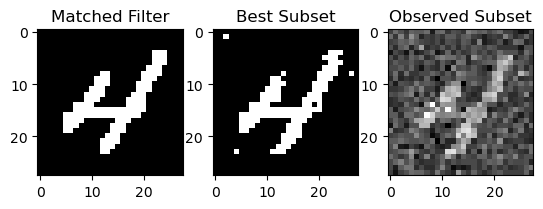

<Figure size 1000x600 with 0 Axes>

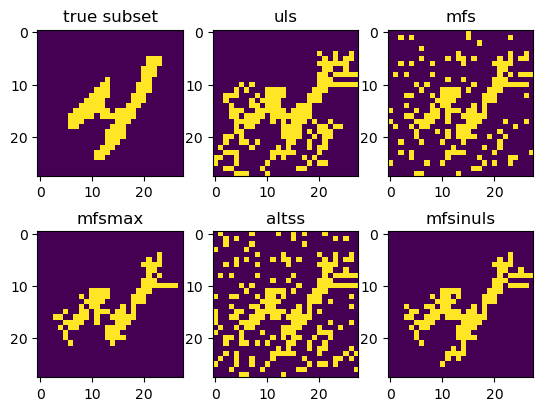

Initial q value (midpoint of q-range): 0.014281 

Penalized score for current qmle 0.014281100262792671 :
 0.0 - 170.0 = -170.0
Penalized score for new qmle 0.0 :
 nan - 170.0 = nan
##################################################################### 0
Initial q value (midpoint of q-range): 0.015916 

Penalized score for current qmle 0.015916221311287844 :
 0.0 - 170.0 = -170.0
Penalized score for new qmle 0.0 :
 nan - 170.0 = nan
##################################################################### 1
Initial q value (midpoint of q-range): 0.025315 

Penalized score for current qmle 0.02531522363316161 :
 0.0 - 170.0 = -170.0
Penalized score for new qmle 0.0 :
 nan - 170.0 = nan
##################################################################### 2
Initial q value (midpoint of q-range): 0.035648 

Penalized score for current qmle 0.03564772664962911 :
 0.0 - 170.0 = -170.0
Penalized score for new qmle 0.0 :
 nan - 170.0 = nan
##########################################################

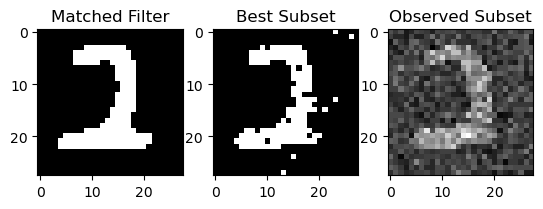

<Figure size 1000x600 with 0 Axes>

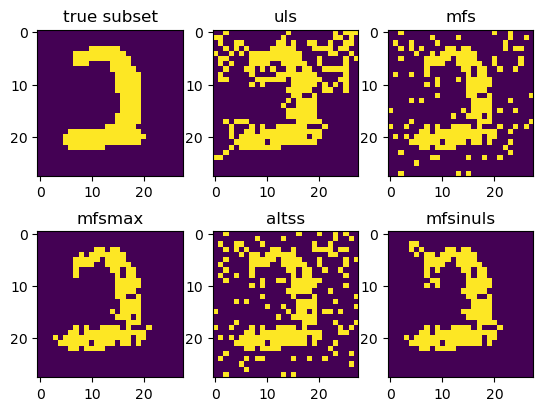

In [40]:
#Output for each competing method

#precision
uls_prec = []
mfs_prec = []
mfsmax_prec = []
altss_prec = []
mfsinuls_prec = []
matched_filter_prec = []

#recall
uls_rec = []
mfs_rec = []
mfsmax_rec = []
altss_rec = []
mfsinuls_rec = []
matched_filter_rec = []

#f1
uls_f1 = []
mfs_f1 = []
mfsmax_f1 = []
altss_f1 = []
mfsinuls_f1 = []
matched_filter_f1 = []


poissons = np.vectorize(lambda x: np.random.poisson(x))

for i in range(2):

    break_rate = 0.5
    filter_true =  test[i]

    baseline = test[i]*10 + 10
    obs = poissons(baseline) 
    lam = poissons(np.ones((784,))*10) + 0.5
    pel = 5
    # obs = np.array([np.random.poisson(lam=i,size=1)[0] for i in (lam * filter_true * break_rate + lam)])

    #NEW MEDIUM MATCHED FILTER SCAN
    new_mf_filter, new_mf_sub = matched_filter(obs, lam, pel, tree)

    #NEW MFS Metrics
    prec = calc_prec(filter_true, new_mf_sub)
    matched_filter_prec.append(prec)

    rec = calc_recall(filter_true, new_mf_sub)
    matched_filter_rec.append(rec)

    matched_filter_f1.append(f1(prec, rec))


    plt.figure(figsize = (10, 6))
    fig, axs = plt.subplots(nrows=2, ncols=3)
    plt.subplot(231)
    #use MNIST training data as filters 
    filters = [train[j] for j in range(len(train))]
    
    #plot true filter
    plt.imshow(filter_true.reshape(28,28))
    plt.title('true subset')
    
    n_point = 784
    P_I_I = 0  # reward: in filter AND subset
    P_I_O = 1 # penalty: in filter and NOT subset
    P_O_I = 1
    
    
    subset_un, subset_con, q_un, q_pel, pel = pel_constructive_single_2(obs, lam)   
    scores = []
    for i in range(len(obs)):
        scores.append(func(q_un, obs[i], lam[i], pel[i]))
    sub = uls_score(scores)
    
    #Upper level set scan statistic
    subset_uls = uls(obs,lam)
    plt.subplot(232)
    plt.imshow(subset_uls.reshape(28,28))
    uls_precision = calc_prec(subset_uls, filter_true)
    uls_prec.append(uls_precision)
    uls_recall = calc_recall(subset_uls, filter_true)
    uls_rec.append(uls_recall)
    uls_f1.append(f1(uls_precision, uls_recall))
    plt.title('uls')    
    
    
    #MFS
    plt.subplot(233)
    plt.imshow(subset_con.reshape(28,28))
    mfs_precision = calc_prec(subset_con, filter_true)
    mfs_prec.append(mfs_precision)
    mfs_recall = calc_recall(subset_con, filter_true)
    mfs_rec.append(mfs_recall)
    mfs_f1.append(f1(mfs_precision, mfs_recall))

    plt.title('mfs')     
    
    binary_img = subset_con.reshape(28,28)
    label_im, nb_labels = ndimage.label(binary_img, structure= [[1,1,1],[1,1,1], [1,1,1]])
    sizes = ndimage.sum(binary_img, label_im, range(nb_labels + 1))
    sub = (label_im == np.argmax(sizes)).astype(int).reshape(-1)
    
    #MFSMAX
    plt.subplot(234)
    plt.imshow(sub.reshape(28,28))
    mfsmax_precision = calc_prec(sub, filter_true)
    mfsmax_prec.append(mfsmax_precision)
    mfsmax_recall = calc_recall(sub, filter_true)
    mfsmax_rec.append(mfsmax_recall)
    mfsmax_f1.append(f1(mfsmax_precision, mfsmax_recall))
    plt.title('mfsmax')
    
    #Additive Linear Time Subset Scan
    plt.subplot(235)
    plt.imshow(subset_un.reshape(28,28))
    altss_precision = calc_prec(subset_un, filter_true)
    altss_prec.append(altss_precision)
    altss_recall = calc_recall(subset_un, filter_true)
    altss_rec.append(altss_recall)
    altss_f1.append(f1(altss_precision, altss_recall))
    plt.title('altss')
    
    subset_un, subset_con, q_un, q_pel, pel = pel_constructive_single_uls(obs, lam)
    plt.subplot(236)
    plt.imshow(subset_con.reshape(28,28))
    mfsinuls_precision = calc_prec(subset_con, filter_true)
    mfsinuls_prec.append(mfsinuls_precision)
    mfsinuls_recall = calc_recall(subset_con, filter_true)
    mfsinuls_rec.append(mfsinuls_recall)
    mfsinuls_f1.append(f1(mfsinuls_precision, mfsinuls_recall))
    plt.title('mfsinuls')   
    plt.show()

In [41]:
#Precision/Recall 

print('ULS precision: ', np.sum(uls_prec)/len(uls_prec))
print('MFS precision: ', np.sum(mfs_prec)/len(mfs_prec))
print('MFSMAX precision: ', np.sum(mfsmax_prec)/len(mfsmax_prec))
print('ALTSS precision: ', np.sum(altss_prec)/len(altss_prec))
print('MFSINULS precision: ', np.sum(mfsinuls_prec)/len(mfsinuls_prec))
print('New Matched Filter precision: ', np.sum(matched_filter_prec)/len(matched_filter_prec))
print('         ')
print('ULS recall: ', np.sum(uls_rec)/len(uls_rec))
print('MFS recall: ', np.sum(mfs_rec)/len(mfs_rec))
print('MFSMAX recall: ', np.sum(mfsmax_rec)/len(mfsmax_rec))
print('ALTSS recall: ', np.sum(altss_rec)/len(altss_rec))
print('MFSINULS recall: ', np.sum(mfsinuls_rec)/len(mfsinuls_rec))
print('MFSINULS recall: ', np.sum(matched_filter_rec)/len(matched_filter_rec))
print('          ')
print('ULS f1: ', np.sum(uls_f1)/len(uls_f1))
print('MFS f1: ', np.sum(mfs_f1)/len(mfs_f1))
print('MFSMAX f1: ', np.sum(mfsmax_f1)/len(mfsmax_f1))
print('ALTSS f1: ', np.sum(altss_f1)/len(altss_f1))
print('MFSINULS f1: ', np.sum(mfsinuls_f1)/len(mfsinuls_f1))
print('NEW MATCHED FILTER f1: ', np.sum(matched_filter_f1)/len(matched_filter_f1))

ULS precision:  0.5016746411483253
MFS precision:  0.5289315297062154
MFSMAX precision:  0.8287873940169572
ALTSS precision:  0.44774152032216546
MFSINULS precision:  0.7654302492809204
New Matched Filter precision:  0.8657134944263657
         
ULS recall:  0.8922315308453923
MFS recall:  0.7958180433427958
MFSMAX recall:  0.771065568095271
ALTSS recall:  0.8022225299453023
MFSINULS recall:  0.8211590389808212
MFSINULS recall:  0.7806736392262708
          
ULS f1:  0.6418262150220913
MFS f1:  0.6334553488271351
MFSMAX f1:  0.7988851727982162
ALTSS f1:  0.5713104161281986
MFSINULS f1:  0.7921248954916715
NEW MATCHED FILTER f1:  0.8206188773130151


In [ ]:
#################################################################################################################
###############################   CIRCLES TEST CASE #############################################################

In [36]:
num_locations = 784
num_hash_tables = 20
hash_tables = []
for i in range(num_hash_tables):
    hash_tables.append(dict(dict(num_element = 0)))
    
p_filter = np.mean(c_train.sum(axis=0)/theta.shape[0])
partition_size = int(round(1/p_filter))
num_partitions_per_hash = 25 #int(round(log_num_filters*(np.log(2)/np.log(1+partition_size))))
#num_partitions = num_partitions_per_hash* num_hash_tables
partitions = []
for i in range(num_hash_tables):
    cur_partitions = []
    for i in range(num_partitions_per_hash):
        cur_partitions.append(np.random.choice(num_locations,size=partition_size,replace=False))
    partitions.append(cur_partitions)

In [37]:
k = -1
step_size = 5
num_filters = c_train.shape[0]
def hashit(thefilter,partitions):
    toreturn = []
    for thepartition in partitions:
        temp = (list(map(lambda x: thefilter[x],thepartition.tolist())) + [1]).index(1)
        toreturn.append(temp)
    return toreturn

for i in range(num_filters):
    thefilter = c_train[i]
    for j in range(num_hash_tables):
        depth = 0
        current_partition = partitions[j][depth*step_size: (depth+1)*step_size]
        fullbitstring = hashit(thefilter,current_partition)
        depth += 1
        root = hash_tables[j]
        root['num_element'] += 1
        if tuple(fullbitstring) not in root:
            root[tuple(fullbitstring)] = []
        current_node = root[tuple(fullbitstring)]
        prev = root
        while(type(current_node) != list):
            current_node['num_element'] += 1
            current_partition = partitions[j][depth*step_size: (depth+1)*step_size]
            fullbitstring = hashit(thefilter,current_partition)
            depth += 1
            if tuple(fullbitstring) not in current_node:
                current_node[tuple(fullbitstring)] = []
            prev = current_node
            current_node = current_node[tuple(fullbitstring)]
        current_node.append(i)
        if depth < 5:
            l = len(current_node)
            if l > 100:
                last_string = fullbitstring
                current_partition = partitions[j][depth*step_size: (depth+1)*step_size]
                new_node = {}
                new_node['num_element'] = l
                for element in current_node:
                    filter_tmp = train[element]
                    fullbitstring = hashit(filter_tmp,current_partition)
                    if tuple(fullbitstring) not in new_node:
                        new_node[tuple(fullbitstring)] = []
                    new_node[tuple(fullbitstring)].append(element)
                prev[tuple(last_string)] = new_node

Initial q value (midpoint of q-range): 0.0021284 

Penalized score for current qmle 0.0021283806631467064 :
 3.3273865432573633 - 20.0 = -16.67261345674264
Penalized score for new qmle 0.1052631468144056 :
 6.248708201393498 - 20.0 = -13.751291798606502
##################################################################### 0
Initial q value (midpoint of q-range): 0.0062335 

Penalized score for current qmle 0.006233510693031652 :
 4.362966057649239 - 20.0 = -15.637033942350762
Penalized score for new qmle 0.1052631468144056 :
 6.248708201393498 - 20.0 = -13.751291798606502
##################################################################### 1
Initial q value (midpoint of q-range): 0.010398 

Penalized score for current qmle 0.010398093412483548 :
 4.8350852972176455 - 20.0 = -15.164914702782355
Penalized score for new qmle 0.1052631468144056 :
 6.248708201393498 - 20.0 = -13.751291798606502
##################################################################### 2
Initial q value (midpoin

C:\Users\joles\AppData\Local\Temp\ipykernel_3268\2537898435.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(222)
C:\Users\joles\AppData\Local\Temp\ipykernel_3268\2537898435.py:105: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(132)
C:\Users\joles\AppData\Local\Temp\ipykernel_3268\2537898435.py:109: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(133)
C:\Users\joles\AppData\Local\Temp\ipykernel_3268\3420364725.py:78: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remov

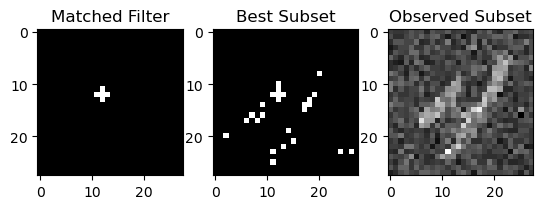

<Figure size 1000x600 with 0 Axes>

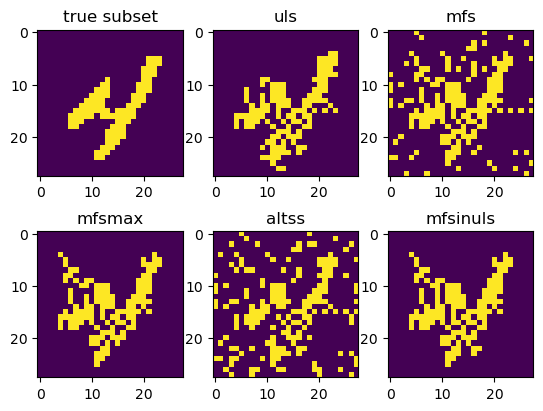

Initial q value (midpoint of q-range): 0.0011932 

Penalized score for current qmle 0.001193179565467181 :
 2.019238454147235 - 20.0 = -17.980761545852765
Penalized score for new qmle 0.12903224973985486 :
 9.404614313269484 - 20.0 = -10.595385686730516
##################################################################### 0
Initial q value (midpoint of q-range): 0.0037146 

Penalized score for current qmle 0.003714571089663814 :
 4.2514400258405765 - 20.0 = -15.748559974159424
Penalized score for new qmle 0.12903224973985486 :
 9.404614313269484 - 20.0 = -10.595385686730516
##################################################################### 1
Initial q value (midpoint of q-range): 0.0085925 

Penalized score for current qmle 0.008592529212426356 :
 5.8530914982325974 - 20.0 = -14.146908501767403
Penalized score for new qmle 0.12903224973985486 :
 9.404614313269484 - 20.0 = -10.595385686730516
##################################################################### 2
Initial q value (mid

C:\Users\joles\AppData\Local\Temp\ipykernel_3268\2537898435.py:92: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(132)
C:\Users\joles\AppData\Local\Temp\ipykernel_3268\2537898435.py:96: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(133)


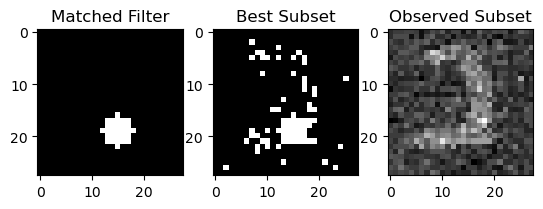

<Figure size 1000x600 with 0 Axes>

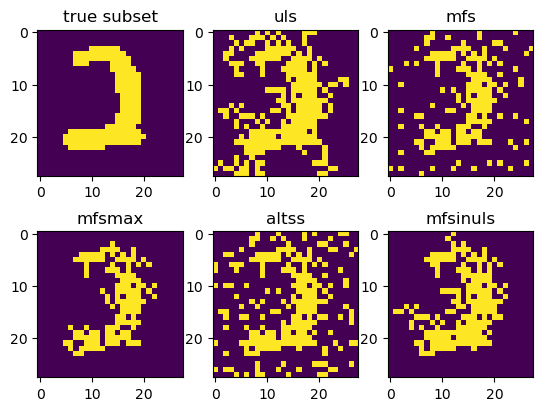

In [42]:
#Output for each competing method

#precision
uls_prec = []
mfs_prec = []
mfsmax_prec = []
altss_prec = []
mfsinuls_prec = []
matched_filter_prec = []

#recall
uls_rec = []
mfs_rec = []
mfsmax_rec = []
altss_rec = []
mfsinuls_rec = []
matched_filter_rec = []

#f1
uls_f1 = []
mfs_f1 = []
mfsmax_f1 = []
altss_f1 = []
mfsinuls_f1 = []
matched_filter_f1 = []


poissons = np.vectorize(lambda x: np.random.poisson(x))

for i in range(2):

    break_rate = 0.5
    filter_true =  test[i]

    baseline = test[i]*10 + 10
    obs = poissons(baseline) 
    lam = poissons(np.ones((784,))*10) + 0.5
    pel = 5
    # obs = np.array([np.random.poisson(lam=i,size=1)[0] for i in (lam * filter_true * break_rate + lam)])

    #NEW MEDIUM MATCHED FILTER SCAN
    new_mf_filter, new_mf_sub = matched_filter(obs, lam, pel, c_tree)

    #NEW MFS Metrics
    prec = calc_prec(filter_true, new_mf_sub)
    matched_filter_prec.append(prec)

    rec = calc_recall(filter_true, new_mf_sub)
    matched_filter_rec.append(rec)

    matched_filter_f1.append(f1(prec, rec))


    plt.figure(figsize = (10, 6))
    fig, axs = plt.subplots(nrows=2, ncols=3)
    plt.subplot(231)
    #use MNIST training data as filters 
    filters = [c_train[j] for j in range(len(c_train))]
    
    #plot true filter
    plt.imshow(filter_true.reshape(28,28))
    plt.title('true subset')
    
    n_point = 784
    P_I_I = 0  # reward: in filter AND subset
    P_I_O = 1 # penalty: in filter and NOT subset
    P_O_I = 1
    
    
    subset_un, subset_con, q_un, q_pel, pel = pel_constructive_single_2(obs, lam)   
    scores = []
    for i in range(len(obs)):
        scores.append(func(q_un, obs[i], lam[i], pel[i]))
    sub = uls_score(scores)
    
    #Upper level set scan statistic
    subset_uls = uls(obs,lam)
    plt.subplot(232)
    plt.imshow(subset_uls.reshape(28,28))
    uls_precision = calc_prec(subset_uls, filter_true)
    uls_prec.append(uls_precision)
    uls_recall = calc_recall(subset_uls, filter_true)
    uls_rec.append(uls_recall)
    uls_f1.append(f1(uls_precision, uls_recall))
    plt.title('uls')    
    
    
    #MFS
    plt.subplot(233)
    plt.imshow(subset_con.reshape(28,28))
    mfs_precision = calc_prec(subset_con, filter_true)
    mfs_prec.append(mfs_precision)
    mfs_recall = calc_recall(subset_con, filter_true)
    mfs_rec.append(mfs_recall)
    mfs_f1.append(f1(mfs_precision, mfs_recall))

    plt.title('mfs')     
    
    binary_img = subset_con.reshape(28,28)
    label_im, nb_labels = ndimage.label(binary_img, structure= [[1,1,1],[1,1,1], [1,1,1]])
    sizes = ndimage.sum(binary_img, label_im, range(nb_labels + 1))
    sub = (label_im == np.argmax(sizes)).astype(int).reshape(-1)
    
    #MFSMAX
    plt.subplot(234)
    plt.imshow(sub.reshape(28,28))
    mfsmax_precision = calc_prec(sub, filter_true)
    mfsmax_prec.append(mfsmax_precision)
    mfsmax_recall = calc_recall(sub, filter_true)
    mfsmax_rec.append(mfsmax_recall)
    mfsmax_f1.append(f1(mfsmax_precision, mfsmax_recall))
    plt.title('mfsmax')
    
    #Additive Linear Time Subset Scan
    plt.subplot(235)
    plt.imshow(subset_un.reshape(28,28))
    altss_precision = calc_prec(subset_un, filter_true)
    altss_prec.append(altss_precision)
    altss_recall = calc_recall(subset_un, filter_true)
    altss_rec.append(altss_recall)
    altss_f1.append(f1(altss_precision, altss_recall))
    plt.title('altss')
    
    subset_un, subset_con, q_un, q_pel, pel = pel_constructive_single_uls(obs, lam)
    plt.subplot(236)
    plt.imshow(subset_con.reshape(28,28))
    mfsinuls_precision = calc_prec(subset_con, filter_true)
    mfsinuls_prec.append(mfsinuls_precision)
    mfsinuls_recall = calc_recall(subset_con, filter_true)
    mfsinuls_rec.append(mfsinuls_recall)
    mfsinuls_f1.append(f1(mfsinuls_precision, mfsinuls_recall))
    plt.title('mfsinuls')   
    plt.show()

In [43]:
#Precision/Recall 

print('ULS precision: ', np.sum(uls_prec)/len(uls_prec))
print('MFS precision: ', np.sum(mfs_prec)/len(mfs_prec))
print('MFSMAX precision: ', np.sum(mfsmax_prec)/len(mfsmax_prec))
print('ALTSS precision: ', np.sum(altss_prec)/len(altss_prec))
print('MFSINULS precision: ', np.sum(mfsinuls_prec)/len(mfsinuls_prec))
print('New Matched Filter precision: ', np.sum(matched_filter_prec)/len(matched_filter_prec))
print('         ')
print('ULS recall: ', np.sum(uls_rec)/len(uls_rec))
print('MFS recall: ', np.sum(mfs_rec)/len(mfs_rec))
print('MFSMAX recall: ', np.sum(mfsmax_rec)/len(mfsmax_rec))
print('ALTSS recall: ', np.sum(altss_rec)/len(altss_rec))
print('MFSINULS recall: ', np.sum(mfsinuls_rec)/len(mfsinuls_rec))
print('MFSINULS recall: ', np.sum(matched_filter_rec)/len(matched_filter_rec))
print('          ')
print('ULS f1: ', np.sum(uls_f1)/len(uls_f1))
print('MFS f1: ', np.sum(mfs_f1)/len(mfs_f1))
print('MFSMAX f1: ', np.sum(mfsmax_f1)/len(mfsmax_f1))
print('ALTSS f1: ', np.sum(altss_f1)/len(altss_f1))
print('MFSINULS f1: ', np.sum(mfsinuls_f1)/len(mfsinuls_f1))
print('NEW MATCHED FILTER f1: ', np.sum(matched_filter_f1)/len(matched_filter_f1))

ULS precision:  0.5587561663143059
MFS precision:  0.513862739143638
MFSMAX precision:  0.7106643356643356
ALTSS precision:  0.4472441874188599
MFSINULS precision:  0.6239867354458364
New Matched Filter precision:  0.11566156615661566
         
ULS recall:  0.8555355535553555
MFS recall:  0.7681229661427682
MFSMAX recall:  0.7681229661427682
ALTSS recall:  0.7628955203212628
MFSINULS recall:  0.8100810081008101
MFSINULS recall:  0.9482758620689655
          
ULS f1:  0.6718290111630794
MFS f1:  0.610319586955101
MFSMAX f1:  0.7322548695939255
ALTSS f1:  0.5633130310549666
MFSINULS f1:  0.7045371338912134
NEW MATCHED FILTER f1:  0.19833260201842917
